In [1]:
# 로드 키
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [3]:
# State 생성
from typing_extensions import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    search_threshold: int
    count: int


graph_builder = StateGraph(AgentState)


In [4]:
# generate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

context_prompt = PromptTemplate.from_template("""
주어진 자료(context)에 기반하여 질문(question)에 대한 답을 주세요

context: {context}
question: {query}
""")


def generate(state: AgentState) -> AgentState:
    query = state["query"]
    context = state.get("context", [])

    if context and len(context) > 0:
        chain = context_prompt | llm | StrOutputParser()
        response = chain.invoke({"context": context, "query": query})
        return {"answer": response, "context": context}
    else:
        chain = llm | StrOutputParser()
        response = chain.invoke(query)
        return {"answer": response}






In [5]:
# qa_eval
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from typing import Literal


# 답변 형식
class EvaledAnswer(BaseModel):
    score: int = Field(..., ge=0, le=20, description="각 기준별 점수를 합한 합산 점수")
    comment: str = Field(description="평가기준에 따른 코멘트")


# 허브에서 프롬프트 가져오기
qa_eval_prompt = PromptTemplate(
    input_variables=["question", "answer"],
    template="""
다음 질문과 답변을 평가해주세요:

질문: {question}
답변: {answer}

평가 기준:
1. 정확성: 답변이 질문에 정확히 답하고 있는가?
2. 완전성: 답변이 충분히 상세하고 완전한가?
3. 명확성: 답변이 이해하기 쉽고 명확한가?
4. 관련성: 답변이 질문과 관련이 있는가?

각 기준에 대해 0-5점으로 평가하고, 평가 기준별 점수를 모두 더한 합산 점수와 각 기준에 대한 개선사항을 주세요
"""
)

# 모델 초기화
structured_qa_eval_llm = ChatOpenAI(model="gpt-5").with_structured_output(EvaledAnswer)


def qa_eval(state: AgentState) -> Literal['enough', 'search']:
    """
    Evaluates the quality and correctness of an answer based on a given query using a predefined evaluation
    chain. The evaluation process is performed through structured prompts and model-based evaluations.

    :param state: The current state of the agent that includes the "answer" and "query" to be evaluated.
    :type state: AgentState
    :return: Updated agent state after the evaluation process.
    :rtype: AgentState
    """
    answer = state["answer"]
    query = state["query"]
    count = state["count"]
    # context = state.get("context", [])
    # print(f"context: {context}")
    search_threshold = state["search_threshold"]

    eval_chain = qa_eval_prompt | structured_qa_eval_llm

    response = eval_chain.invoke({"answer": answer, "question": query})

    score = response.score
    print(f"score: {score}")

    if score > search_threshold or count >= 3:
        return 'enough'

    state["count"] = count + 1
    return 'search'



In [7]:
# web_search
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)


def web_search(state: AgentState) -> AgentState:
    """
    Executes a web search for the provided query using the tavily_search_tool
    and updates the context in the state with the obtained results.

    :param state: The input state containing the query to be searched.
    :type state: AgentState
    :return: An updated state including the search results within the context.
    :rtype: AgentState
    """
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    print(f"web search results: {results}")

    return {"context": results}

In [8]:
graph_builder.add_node("generate", generate)
graph_builder.add_node("web_search", web_search)

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "generate")
graph_builder.add_conditional_edges(
    'generate',
    qa_eval,
    {
        'enough': END,
        'search': 'web_search'
    }
)
graph_builder.add_edge("web_search", "generate")

In [10]:
graph = graph_builder.compile()

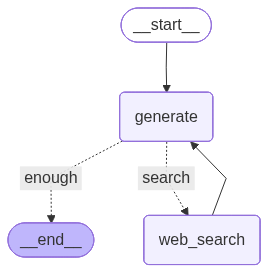

In [11]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from pprint import pprint

initial_state = {
    'query': '2025년 삼성전자 주식의 주가를 요약해줘 주가를 잘 모르면 인터넷에서 참고해줘',
    'search_threshold': 18,
    'count': 0
}
# graph.invoke(initial_state)
# 스트림 모드
for update in graph.stream(initial_state, stream_mode="updates"):
    print(update)


score: 15
{'generate': {'answer': '죄송하지만, 저는 실시간 정보에 접근할 수 없으며, 2025년 삼성전자 주식의 주가를 예측하거나 제공할 수 없습니다. 주식 가격은 여러 요인에 따라 변동하며, 정확한 예측은 어렵습니다. 주식 관련 최신 정보를 얻으려면 금융 뉴스 웹사이트, 증권사 리포트 또는 주식 거래 플랫폼을 참고하시기 바랍니다.'}}
web search results: [{'title': '삼성 전자 주가 전망: 2025년, 2026년', 'url': 'https://wonforecast.com/samsung-electronics', 'content': '|  |  |  |  |  |  |\n ---  ---  --- |\n| 년도 | 달 | 최대 | 최소 | 종료 | 총변화% |\n| 2025 | 8월 | 75718 | 68300 | 74233 | 7.7% |\n| 2025 | 9월 | 79054 | 74233 | 77504 | 12.5% |\n| 2025 | 10월 | 90479 | 77504 | 88705 | 28.7% |\n| 2025 | 11월 | 96919 | 88705 | 95019 | 37.9% |\n| 2025 | 12월 | 98141 | 94293 | 96217 | 39.6% |\n| 2026 | 1월 | 96217 | 89001 | 90817 | 31.8% |\n| 2026 | 2월 | 99942 | 90817 | 97982 | 42.2% |\n| 2026 | 3월 | 103947 | 97982 | 101909 | 47.9% |\n| 2026 | 4월 | 102385 | 98369 | 100377 | 45.7% | [...] | 2026 | 5월 | 100496 | 96555 | 98525 | 43.0% |\n| 2026 | 6월 | 98525 | 89764 | 91596 | 32.9% |\n| 2026 | 7월 | 91596 | 85093 | 86830 | 26.0% |\n| 2026 | 8월 | 86830

KeyboardInterrupt: 